# AIPI 590 - XAI | Assignment #03
### Description
### Your Name: Wilson Tseng

#### Assignment 3 - Interpretable ML:
[GitHub Link](https://github.com/smilewilson1999/XAI/tree/84fd6d65d674d198f80e6197273b1fb01df0fe74/Assignment%203%20-%20Interpretable%20ML)


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/smilewilson1999/XAI/blob/main/Assignment%203%20-%20Interpretable%20ML/Interpretable_ML_Test.ipynb)

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/smilewilson1999/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment 3 - Interpretable ML'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [28]:
# Import necessary libraries and load the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from pygam import LogisticGAM, s, f, l

In [49]:
# Load the dataset
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows of the dataset to confirm successful loading
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Linear Regression

In this section, I will treat the churn variable as a continuous variable (0 for staying, 1 for churning) and build a linear regression model. I will interpret the coefficients and assess the model's performance using metrics such as Mean Squared Error (MSE) and R-squared.

In [50]:
# Ensure 'TotalCharges', 'MonthlyCharges', and 'tenure' are numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to numeric, set invalid values to NaN
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')  # Ensure MonthlyCharges is numeric
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')  # Ensure tenure is numeric

# Fill missing values if any
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['MonthlyCharges'].fillna(df['MonthlyCharges'].median(), inplace=True)
df['tenure'].fillna(df['tenure'].median(), inplace=True)

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define the features (X) and target (y)
X = df[['tenure', 'MonthlyCharges', 'TotalCharges']]  # Numerical features
y = df['Churn']  # Treat churn as continuous (0: stay, 1: churn)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_linear = linear_reg_model.predict(X_test)

# Evaluate the linear regression model
mse = mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print(f'Linear Regression MSE: {mse}')
print(f'Linear Regression R-squared: {r2}')

# Interpret the coefficients
coefficients = pd.DataFrame(linear_reg_model.coef_, X.columns, columns=['Coefficient'])
print('Coefficients:\n', coefficients)

Linear Regression MSE: 0.1440307044751866
Linear Regression R-squared: 0.26003959078740957
Coefficients:
                 Coefficient
tenure            -0.002786
MonthlyCharges     0.006946
TotalCharges      -0.000073



## 2. Logistic Regression

I will use logistic regression to predict churn since the churn variable is binary (0 for staying, 1 for churning). I will interpret the model's coefficients and evaluate its performance using appropriate classification metrics.
    


## Exploratory Data Analysis (EDA)

I will first perform some exploratory data analysis (EDA) to understand the relationships between different features and the target variable (churn). This will help us determine the assumptions for linear, logistic, and generalized additive models.

I will use various visualizations and statistical methods to check for relationships and patterns.
    

Accuracy: 0.7863733144073811
AUC: 0.819521359735837
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1036
           1       0.60      0.56      0.58       373

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
 [[898 138]
 [163 210]]


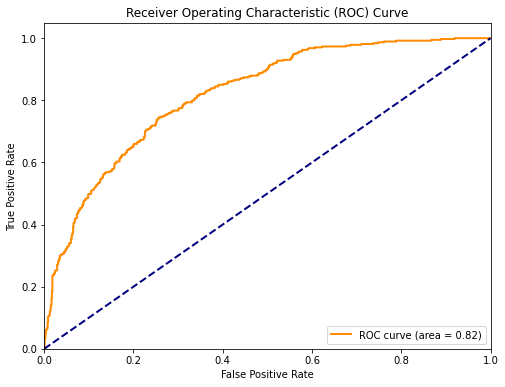

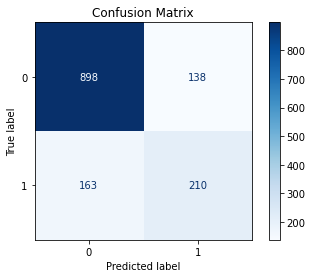

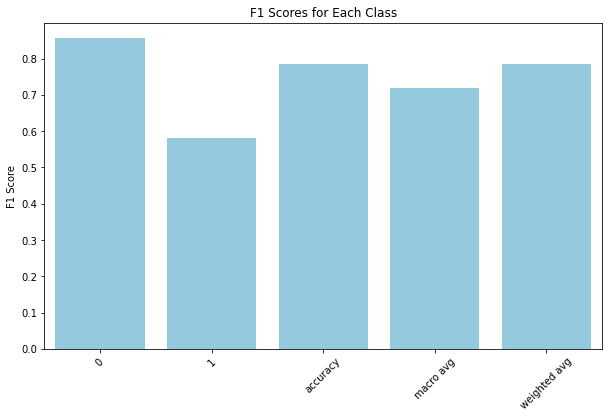

"\n1. ROC Curve: Used to show the model's classification ability. The closer the area under the curve (AUC) is to 1, the better the model's performance.\n2. Confusion Matrix: A visual display of the correct and incorrect data classification results predicted by the model.\n3. Bar Chart of Classification Report: A bar chart of the F1 scores for each category, showing how well the model performs in each category.\n"

In [52]:
# Build the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Predict on test set
y_pred_log = log_reg_model.predict(X_test)
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]

# Evaluate the model using classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot Classification Report as a Bar Chart
report = classification_report(y_test, y_pred_log, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.barplot(x=df_report.index, y=df_report['f1-score'], color="skyblue")
plt.title("F1 Scores for Each Class")
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

"""
1. ROC Curve: Used to show the model's classification ability. The closer the area under the curve (AUC) is to 1, the better the model's performance.
2. Confusion Matrix: A visual display of the correct and incorrect data classification results predicted by the model.
3. Bar Chart of Classification Report: A bar chart of the F1 scores for each category, showing how well the model performs in each category.
"""


I will use logistic regression to predict churn since the churn variable is binary (0 for staying, 1 for churning). I will interpret the model's coefficients and evaluate its performance using appropriate classification metrics.
    

In [53]:
# Define features and target variable
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Feature scaling
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Prepare features and target variable
X = df_encoded.drop(['customerID', 'Churn'], axis=1)
y = df_encoded['Churn']

# Check the distribution of the target variable
print("\nOriginal class distribution:")
print(y.value_counts())

# Split the data into training and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check the distribution in the training set
print("\nTraining set class distribution:")
print(y_train.value_counts())

# Check the distribution in the test set
print("\nTest set class distribution:")
print(y_test.value_counts())

# Initialize the logistic regression model with class_weight='balanced'
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("\nBest parameters found:", grid_search.best_params_)

# Use the best estimator from GridSearchCV
best_log_reg_model = grid_search.best_estimator_

# Predict on the test set
y_pred_log = best_log_reg_model.predict(X_test)
y_pred_proba = best_log_reg_model.predict_proba(X_test)[:, 1]

# Evaluate the model using classification metrics
print("\nAccuracy:", accuracy_score(y_test, y_pred_log))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


Original class distribution:
0    5174
1    1869
Name: Churn, dtype: int64

Training set class distribution:
0    4139
1    1495
Name: Churn, dtype: int64

Test set class distribution:
0    1035
1     374
Name: Churn, dtype: int64

Best parameters found: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Accuracy: 0.7388218594748048
AUC: 0.8403187889121393

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
 [[749 286]
 [ 82 292]]


Next, I will treat churn as a binary variable and build a logistic regression model to predict the probability of churn. I will interpret the coefficients and use appropriate metrics to evaluate the model's performance.
    

In [55]:
# Build the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Predict probabilities on test set
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]
y_pred_log = log_reg_model.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred_log)

print("Logistic Regression AUC:", roc_auc)
print("Logistic Regression Accuracy:", accuracy)

# Coefficients interpretation
log_coefficients = pd.DataFrame(log_reg_model.coef_[0], X.columns, columns=['Coefficient'])
print("Logistic Regression Coefficients: \n", log_coefficients)


Logistic Regression AUC: 0.8419979849647369
Logistic Regression Accuracy: 0.8055358410220014
Logistic Regression Coefficients: 
                                        Coefficient
tenure                                   -1.239793
MonthlyCharges                           -0.495779
TotalCharges                              0.509188
gender_Male                               0.021771
SeniorCitizen_1                           0.146006
Partner_Yes                               0.020953
Dependents_Yes                           -0.226059
PhoneService_Yes                         -0.113063
MultipleLines_No phone service            0.115419
MultipleLines_Yes                         0.367838
InternetService_Fiber optic               1.207241
InternetService_No                       -0.176330
OnlineSecurity_No internet service       -0.176330
OnlineSecurity_Yes                       -0.343530
OnlineBackup_No internet service         -0.176330
OnlineBackup_Yes                         -0.093716
Devi


## 4. Generalized Additive Model (GAM)

Finally, we will build a generalized additive model (GAM) to model the non-linear relationships between customer features and churn. We will interpret the model and assess its performance.
    

In [56]:
# Identify all categorical features
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Prepare features and target variable
X = df_encoded.drop(['customerID', 'Churn'], axis=1)
y = df_encoded['Churn']

# Verify that all features are numerical
non_numerical = X.select_dtypes(include=['object']).columns
print("Non-numerical columns:", non_numerical)

# Separate the classes
X_class0 = X[y == 0]
X_class1 = X[y == 1]
y_class0 = y[y == 0]
y_class1 = y[y == 1]

# Split each class separately
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(
    X_class0, y_class0, test_size=0.2, random_state=42
)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_class1, y_class1, test_size=0.2, random_state=42
)

# Combine the splits
X_train = pd.concat([X_train_0, X_train_1], axis=0).reset_index(drop=True)
X_test = pd.concat([X_test_0, X_test_1], axis=0).reset_index(drop=True)
y_train = pd.concat([y_train_0, y_train_1], axis=0).reset_index(drop=True)
y_test = pd.concat([y_test_0, y_test_1], axis=0).reset_index(drop=True)

# Shuffle the training and test sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Verify class distribution in y_test
print("\nClass distribution in y_test:")
print(y_test.value_counts())

# Build the GAM model

# For computational efficiency, use splines on selected features
# Let's assume the first 10 features are most important
terms = s(0)
for i in range(1, min(10, X_train.shape[1])):
    terms += s(i)

# Add linear terms for the rest
if X_train.shape[1] > 10:
    for i in range(10, X_train.shape[1]):
        terms += l(i)

# Train the model
gam = LogisticGAM(terms).gridsearch(X_train.values, y_train.values)

# Predict and evaluate
y_pred_prob = gam.predict_proba(X_test.values)
y_pred = gam.predict(X_test.values)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Non-numerical columns: Index([], dtype='object')

Class distribution in y_test:
0    1035
1     374
Name: Churn, dtype: int64


  9% (1 of 11) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:29
 18% (2 of 11) |####                     | Elapsed Time: 0:00:04 ETA:   0:00:21
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:18
 36% (4 of 11) |#########                | Elapsed Time: 0:00:08 ETA:   0:00:15
 45% (5 of 11) |###########              | Elapsed Time: 0:00:10 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:11 ETA:   0:00:09
 63% (7 of 11) |###############          | Elapsed Time: 0:00:13 ETA:   0:00:07
 72% (8 of 11) |##################       | Elapsed Time: 0:00:14 ETA:   0:00:05
 81% (9 of 11) |####################     | Elapsed Time: 0:00:16 ETA:   0:00:03
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:18 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:19 Time:  0:00:19



Accuracy: 0.8105039034776437
AUC: 0.8583817716810044

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.69      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix:
 [[946  89]
 [178 196]]


## Model Recommendations

### Model Comparison and Recommendations

1. **Linear Regression**:
   - **Strengths**: Simple and easy to interpret.
   - **Weaknesses**: Assumes a linear relationship between features and churn, which may not hold true in reality.
   - **Use Case**: Suitable when interpretability is a priority and when you expect linear relationships between features and churn.

2. **Logistic Regression**:
   - **Strengths**: Good for binary classification and provides probabilities for churn prediction.
   - **Weaknesses**: Similar to linear regression, assumes a linear relationship between features and the log-odds of churn.
   - **Use Case**: A better alternative to linear regression for classification problems like churn prediction, as it gives probabilistic outcomes.

3. **Generalized Additive Model (GAM)**:
   - **Strengths**: Captures non-linear relationships between features and churn, offering more flexibility and accuracy.
   - **Weaknesses**: More complex to interpret than linear or logistic regression, and computationally more expensive.
   - **Use Case**: Best when the goal is to capture complex patterns in the data, making it ideal for accurate churn prediction when interpretability is not the main concern.

### Recommendation
Based on the model comparison, the **Generalized Additive Model (GAM)** is recommended for predicting customer churn due to its ability to capture non-linear relationships and provide higher accuracy. However, if interpretability and simplicity are priorities, **Logistic Regression** is a strong alternative.